In [1]:
from rtlsdr import RtlSdr
import numpy as np
import matplotlib.pyplot as plt
import pyModeS as pms

In [2]:
sdr = RtlSdr()
fs = 2000000;
sdr.set_sample_rate(fs)
sdr.set_center_freq(1090e6)
sdr.set_gain(38.6)
N_Samples = 2048000

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!
Exact sample rate is: 2000000.052982 Hz


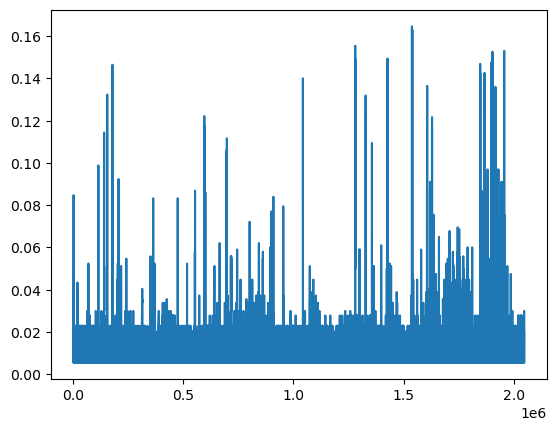

In [35]:
y = abs(sdr.read_samples(N_Samples)) 
plt.plot(y)
plt.show()

In [36]:
# Calculate mean and standard deviation of samples to identify noise floor
y_mean = np.mean(y)
print(y_mean)
y_std=np.std(y)
print(y_std)

0.006539669700383188
0.004205976289728584


In [37]:
# Set noise floor and identify all samples above noise floor
alpha = 5
sig_thresh = y_mean + alpha*y_std
idx_sig = np.nonzero(y > sig_thresh)[0]
print(sig_thresh)
print(len(idx_sig))

0.02756955114902611
10261


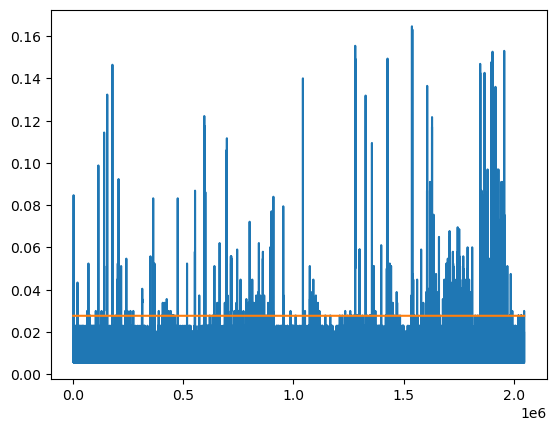

In [38]:
plt.plot(y)
plt.plot([sig_thresh]*len(y))
plt.show()

In [39]:
def detectPreambleXcorr(chunk,corrthresh):    
    preamble = np.array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]) 

    chunk_mean = np.mean(chunk)
    c = np.array(chunk) - chunk_mean
    b = c * preamble
    numerator = np.sum(b)         
    
    a1 = np.linalg.norm(c)            
    a2 = np.linalg.norm(preamble)      
    
    denominator = a1*a2
    
    crossCorr = numerator/denominator

    if (crossCorr>corrthresh):
        return 1              #True = 1.  Returns true if the calculated crossCorr is greater than corrthresh
    else:
        return 0         

In [40]:
idx_corr = []

for n in idx_sig:
    x = abs(y[n:n+16])
    a = detectPreambleXcorr(x,0.5)
    if a == 1:
        idx_corr.append(n)

print ('idx_corr are ' , idx_corr)
print ('length of idx_corr is',len(idx_corr))

idx_corr are  [19187, 19295, 68767, 68949, 75115, 128491, 140178, 140402, 140414, 154150, 177778, 177894, 199609, 217278, 217403, 240850, 350415, 350451, 368724, 368897, 368932, 368949, 406401, 415369, 424479, 453538, 516627, 516864, 552060, 552184, 595064, 595094, 595150, 641168, 664617, 664656, 664668, 664675, 695550, 695664, 695674, 697550, 697615, 697663, 697668, 697670, 700930, 700960, 701048, 716512, 759765, 786134, 786176, 800927, 800978, 801036, 803516, 820466, 840039, 843024, 843053, 843170, 843186, 843220, 843227, 843253, 861078, 861196, 861315, 894357, 894384, 895267, 953892, 1042912, 1042997, 1043030, 1043037, 1043039, 1043149, 1074148, 1280468, 1280600, 1280634, 1299451, 1299570, 1301451, 1327558, 1327701, 1327747, 1334624, 1363997, 1364126, 1364133, 1398627, 1398745, 1398752, 1425311, 1425418, 1425425, 1425435, 1427311, 1427417, 1427427, 1427429, 1427436, 1430338, 1430433, 1443408, 1443454, 1538047, 1538161, 1538163, 1540047, 1540160, 1540162, 1540165, 1540167, 1542144, 1

In [41]:
msgs = []
for i in range(len(idx_corr)):
    msgs.append(abs(y[idx_corr[i]:idx_corr[i]+16+112*2]))

msgs = np.vstack(msgs)
msgs.shape

(229, 240)

In [42]:
def bool2Hex(lst):
    tmp =  ''.join(['1' if x else '0' for x in lst])
    return hex(int(tmp,2))[2:]

In [43]:
output = []
count=0
for n in range(msgs.shape[0]):
    # Mask because on-off keying
    bits = msgs[n,16::2] > msgs[n,17::2]
    msg = bool2Hex(bits)
    crc = pms.crc(msg)
    crc_str = str(crc).encode()
    crc_bool = np.frombuffer(crc_str, dtype=np.int8) - np.int8(48)
    if (all (crc_bool==0)):  #Long
        count=count+1
        print(count,")CRC OK, DF",pms.df(msg),"ICAO:",pms.adsb.icao(msg),"typecode:",pms.adsb.typecode(msg),"MSG:",msg)
        output.append(msg)
    else :   #short or nothing
        crc = pms.crc(msg[:14])  # look at a short message
        crc_str = str(crc).encode()
        crc_bool = np.frombuffer(crc_str, dtype=np.int8) - np.int8(48)
        if (all (crc_bool==0)):  # short message
            count=count+1
            print(count,")CRC OK, DF",pms.df(msg),"MSG:",msg[:14])
            output.append(msg)

1 )CRC OK, DF 11 MSG: 5d80145baaf679
2 )CRC OK, DF 17 ICAO: 80154b typecode: 11 MSG: 8d80154b582904849c6c381ee32c
3 )CRC OK, DF 17 ICAO: 80145b typecode: 11 MSG: 8d80145b581954840856429fd97f
4 )CRC OK, DF 17 ICAO: 80161c typecode: 19 MSG: 8d80161c9914f81018280ca29a2e
5 )CRC OK, DF 17 ICAO: 80159a typecode: 28 MSG: 8d80159ae1011c00000000f1aa54
6 )CRC OK, DF 17 ICAO: 80154b typecode: 29 MSG: 8d80154bea0dc858015c08ffa44a
7 )CRC OK, DF 17 ICAO: 80145b typecode: 19 MSG: 8d80145b9924a680582888f8b6af
8 )CRC OK, DF 17 ICAO: 80145b typecode: 11 MSG: 8d80145b581950ba56be31d751a1
9 )CRC OK, DF 17 ICAO: 80161c typecode: 19 MSG: 8d80161c9914fb0f18280c6ba07f
10 )CRC OK, DF 17 ICAO: 801608 typecode: 11 MSG: 8d8016085883c1701eabb0b4a015


In [44]:
def print_msg(msg):
    icao_address = pms.common.icao(msg)
    print(f"ICAO Address: {icao_address}")
    
    # Decode the message type
    df = pms.common.df(msg)
    print(f"Downlink Format: {df}")
    
    # Identify the message type code
    tc = pms.common.typecode(msg)
    print(f"Type Code: {tc}")
    
    # Decode velocity if it is a velocity message
    if tc == 19:
        speed, heading, vertical_rate, speed_type = pms.adsb.velocity(msg)
        print(f"Speed: {speed}, Heading: {heading}, Vertical Rate: {vertical_rate}, Type: {speed_type}")

In [45]:
for msg in output:
    print('*'*50)
    print(msg)
    print_msg(msg)

**************************************************
5d80145baaf67910a00000000008
ICAO Address: 80145b
Downlink Format: 11
Type Code: -1
**************************************************
8d80154b582904849c6c381ee32c
ICAO Address: 80154b
Downlink Format: 17
Type Code: 11
**************************************************
8d80145b581954840856429fd97f
ICAO Address: 80145b
Downlink Format: 17
Type Code: 11
**************************************************
8d80161c9914f81018280ca29a2e
ICAO Address: 80161c
Downlink Format: 17
Type Code: 19
Speed: 277, Heading: 297.2108699710525, Vertical Rate: -576, Type: GS
**************************************************
8d80159ae1011c00000000f1aa54
ICAO Address: 80159a
Downlink Format: 17
Type Code: 28
**************************************************
8d80154bea0dc858015c08ffa44a
ICAO Address: 80154b
Downlink Format: 17
Type Code: 29
**************************************************
8d80145b9924a680582888f8b6af
ICAO Address: 80145b
Downlink Format: 17

In [56]:
msg1 = '8d80145b581954840856429fd97f'
msg2 = '8d80145b581950ba56be31d751a1'

pms.hex2bin(msg1)[53], pms.hex2bin(msg2)[53]

('1', '0')

In [57]:
pos = pms.adsb.position(msg1,msg2,0,1)

In [58]:
print('position is',pos)

position is (19.091812133789062, 73.10229165213448)
